In [1]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime as dt

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# benchmark stuff
from buildings_bench.data import load_pandas_dataset, benchmark_registry
from buildings_bench.evaluation.managers import DatasetMetricsManager
from buildings_bench import BuildingTypes

import torch

import shap

lag = 168

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_path = Path('/projects/foundation/eulp/BuildingsBench/')

In [4]:
metrics_manager = DatasetMetricsManager()

benchmark_registry = ['smart']

In [5]:
dataset = 'smart'

In [6]:
dataset_generator = load_pandas_dataset('smart', dataset_path)

In [7]:
dataset_generator.building_type

'residential'

In [8]:
building_types_mask = (BuildingTypes.RESIDENTIAL_INT * torch.ones([1,24,1])).bool()

In [9]:
for building_name, bldg_df in dataset_generator:
    if building_name == 'HomeD':
        break
    # print(building_name)

In [10]:
bldg_df

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,0.063468,0.258819,0.965926,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 02:00:00,0.064494,0.500000,0.866025,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 03:00:00,0.049928,0.707107,0.707107,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 04:00:00,0.066187,0.866025,0.500000,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 05:00:00,0.048459,0.965926,0.258819,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,1.600637,-0.866025,0.500000,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2016-12-31 21:00:00,1.526326,-0.707107,0.707107,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2016-12-31 22:00:00,1.741415,-0.500000,0.866025,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [11]:
from datetime import timezone, timedelta
import datetime
def get_weather_pandas(path_to_csv: str) -> pd.DataFrame:
    weather_data = pd.read_csv(path_to_csv)
    
    # Unix timestamp to UTC-5
    weather_data['time'] = weather_data['time'].apply(lambda x: (dt.fromtimestamp(x, timezone.utc) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
    
    weather_data.rename(columns={'time' : 'timestamp'}, inplace=True)
    weather_data = weather_data.set_index('timestamp')
    weather_data.index = pd.to_datetime(weather_data.index, format='%Y-%m-%d %H:%M:%S')
    
    assert weather_data[weather_data.index.duplicated()].empty # making sure there's no duplicates
    
    return weather_data

In [12]:
# weather_data = pd.read_csv('weather_homeB.csv')
weather_2016 = get_weather_pandas('HomeD/homeD2016.csv')
weather_2015 = get_weather_pandas('HomeD/homeD2015.csv')
# weather_2014 = get_weather_pandas('HomeC/homeC2014.csv')
weather_data = pd.concat([weather_2016])

In [13]:
weather_data

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
timestamp,,,,,,,,,,,,,
2016-01-01 00:00:00,34.98,clear-night,0.64,10.00,Clear,27.98,1016.78,8.88,NaN,275.0,0.0,23.92,0.0
2016-01-01 01:00:00,34.79,partly-cloudy-night,0.64,9.86,Mostly Cloudy,27.45,1016.20,9.48,0.91,273.0,0.0,23.87,0.0
2016-01-01 02:00:00,34.08,clear-night,0.65,10.00,Clear,27.64,1015.99,7.56,NaN,272.0,0.0,23.68,0.0
2016-01-01 03:00:00,34.02,clear-night,0.67,9.92,Clear,28.65,1015.98,5.98,NaN,270.0,0.0,24.23,0.0
2016-01-01 04:00:00,34.00,partly-cloudy-night,0.68,10.00,Mostly Cloudy,27.43,1015.55,7.75,0.75,259.0,0.0,24.57,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,31.20,clear-night,0.64,10.00,Clear,24.54,1027.76,6.99,0.07,272.0,0.0,20.59,0.0
2016-12-31 20:00:00,26.25,clear-night,0.77,10.00,Clear,26.25,1028.92,1.21,0.00,234.0,0.0,20.01,0.0
2016-12-31 21:00:00,22.26,clear-night,0.81,10.00,Clear,22.26,1029.96,1.48,0.01,101.0,0.0,17.42,0.0


In [14]:
weather_data[['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']][1:]

,temperature,humidity,cloudCover,windBearing,pressure
timestamp,,,,,
2016-01-01 01:00:00,34.79,0.64,0.91,273.0,1016.20
2016-01-01 02:00:00,34.08,0.65,NaN,272.0,1015.99
2016-01-01 03:00:00,34.02,0.67,NaN,270.0,1015.98
2016-01-01 04:00:00,34.00,0.68,0.75,259.0,1015.55
2016-01-01 05:00:00,33.89,0.69,NaN,267.0,1015.39
...,...,...,...,...,...
2016-12-31 19:00:00,31.20,0.64,0.07,272.0,1027.76
2016-12-31 20:00:00,26.25,0.77,0.00,234.0,1028.92
2016-12-31 21:00:00,22.26,0.81,0.01,101.0,1029.96


In [15]:
# bldg_df_1 = bldg_df[:-1]
# bldg_df_1[['temperature', 'humidity']] = weather_data[['temperature', 'humidity']][1:]

In [16]:
bldg_df_1 = bldg_df.join(weather_data[['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']])

In [17]:
# bldg_df_1 = bldg_df_1.dropna()

In [18]:
bldg_df_1

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity,cloudCover,windBearing,pressure
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,0.063468,0.258819,0.965926,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,34.79,0.64,0.91,273.0,1016.20
2016-01-01 02:00:00,0.064494,0.500000,0.866025,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,34.08,0.65,NaN,272.0,1015.99
2016-01-01 03:00:00,0.049928,0.707107,0.707107,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,34.02,0.67,NaN,270.0,1015.98
2016-01-01 04:00:00,0.066187,0.866025,0.500000,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,34.00,0.68,0.75,259.0,1015.55
2016-01-01 05:00:00,0.048459,0.965926,0.258819,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,33.89,0.69,NaN,267.0,1015.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,1.600637,-0.866025,0.500000,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,True,False,True,26.25,0.77,0.00,234.0,1028.92
2016-12-31 21:00:00,1.526326,-0.707107,0.707107,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,True,False,True,22.26,0.81,0.01,101.0,1029.96
2016-12-31 22:00:00,1.741415,-0.500000,0.866025,-2.449294e-16,1.000000,False,False,False,False,False,...,False,False,True,False,True,20.47,0.84,0.00,167.0,1030.77


In [19]:
bldg_df_1.index

DatetimeIndex(['2016-01-01 01:00:00', '2016-01-01 02:00:00',
               '2016-01-01 03:00:00', '2016-01-01 04:00:00',
               '2016-01-01 05:00:00', '2016-01-01 06:00:00',
               '2016-01-01 07:00:00', '2016-01-01 08:00:00',
               '2016-01-01 09:00:00', '2016-01-01 10:00:00',
               ...
               '2016-12-31 15:00:00', '2016-12-31 16:00:00',
               '2016-12-31 17:00:00', '2016-12-31 18:00:00',
               '2016-12-31 19:00:00', '2016-12-31 20:00:00',
               '2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq='H')

In [20]:
def train_loop(df: pd.DataFrame):
    bldg_train, bldg_test = train_test_split(df, test_size=0.25, shuffle=False)
    forecaster = ForecasterAutoreg(
        regressor        = LGBMRegressor(max_depth=-1, n_estimators=100, n_jobs=24),
        lags             = lag
    )
    forecaster.fit(
        y               = bldg_train['power'],
        exog            = bldg_train[[key for key in bldg_train.keys() if key != 'power']]
    )    
    print(f'fit lightgbm to {building_name} training start {bldg_train.index[0]} end {bldg_train.index[-1]}')
    metrics_manager = DatasetMetricsManager()
    metrics_manager.add_building_to_dataset_if_missing(
        dataset, f'{building_name}')

    pred_days = (len(bldg_test) - lag - 24) // 24

    #maes = []
    for i in range(pred_days):

        seq_ptr =lag + 24 * i

        last_window  = bldg_test.iloc[seq_ptr - lag : seq_ptr]
        ground_truth = bldg_test.iloc[seq_ptr : seq_ptr + 24]

        predictions = forecaster.predict(
            steps       = 24,
            last_window = last_window['power'],
            exog        = ground_truth[[key for key in bldg_test.keys() if key != 'power']]
        )

        #mae = np.mean(abs(ground_truth['power'].values - predictions.values))
        #maes += [mae]
        metrics_manager(
            dataset,
            f'{building_name}',
            torch.from_numpy(ground_truth['power'].values).float().view(1,24,1),
            torch.from_numpy(predictions.values).float().view(1,24,1),
            building_types_mask
        )  
        
    forecaster.regressor.fit(bldg_train[[key for key in bldg_train.keys() if key != 'power']], bldg_train['power'])
    explainer = shap.TreeExplainer(forecaster.regressor)
    # shap_values = explainer.shap_values(bldg_test[[key for key in bldg_test.keys() if key != 'power']])
        
    return metrics_manager.summary()['value'][0], explainer, bldg_test[[key for key in bldg_test.keys() if key != 'power']]

In [ ]:
bldg_df_1[[key for key in bldg_df_1.keys() if key != 'power']]

In [21]:
acc, explainer, valid_x = train_loop(bldg_df_1)
acc

fit lightgbm to HomeD training start 2016-01-01 01:00:00 end 2016-10-01 12:00:00


0.8305130004882812

In [87]:
acc

0.8305130004882812

In [22]:
shap_values = explainer.shap_values(valid_x)

In [23]:
shap_values

array([[ 0.00018045, -0.04450944, -0.03092195, ...,  0.04610094,
        -0.00056754, -0.01037697],
       [-0.01001741, -0.0430662 , -0.04805423, ...,  0.03704022,
         0.00263828, -0.02257459],
       [-0.03354156, -0.02661823, -0.03774005, ...,  0.03818713,
        -0.00136939,  0.03692855],
       ...,
       [-0.16283838,  0.02444382, -0.04956661, ..., -0.03258133,
        -0.06154014, -0.07343297],
       [-0.08774372,  0.03878003, -0.04705614, ..., -0.02043421,
        -0.0553906 , -0.06188458],
       [-0.05690785,  0.11107066, -0.04064981, ...,  0.02252916,
        -0.03270974,  0.11143323]])

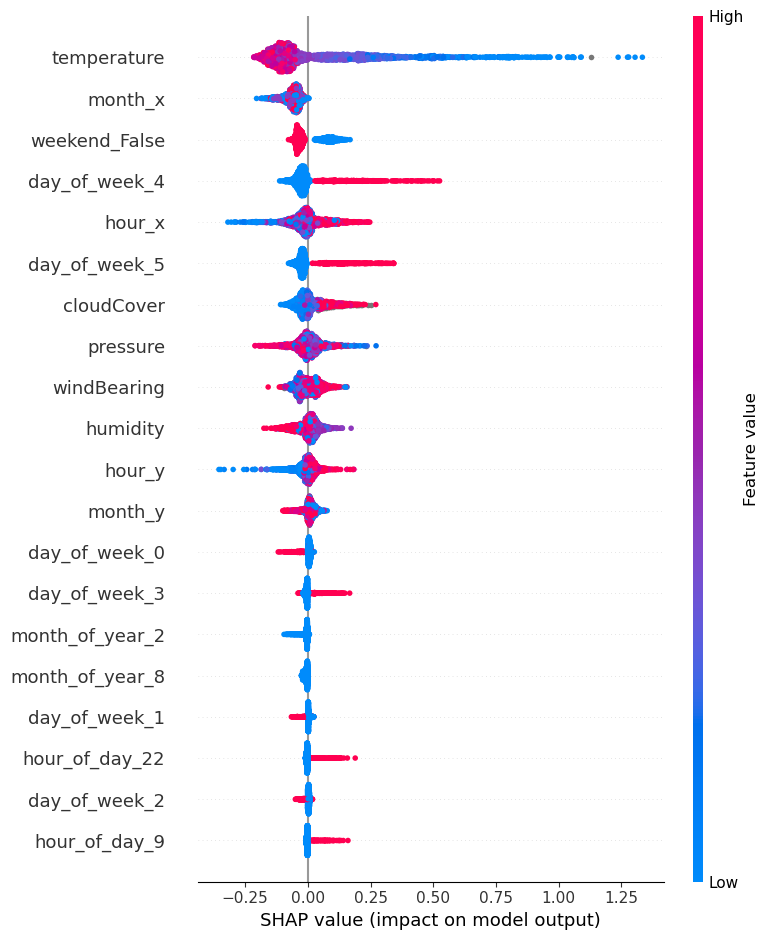

In [24]:
shap.summary_plot(shap_values, valid_x)


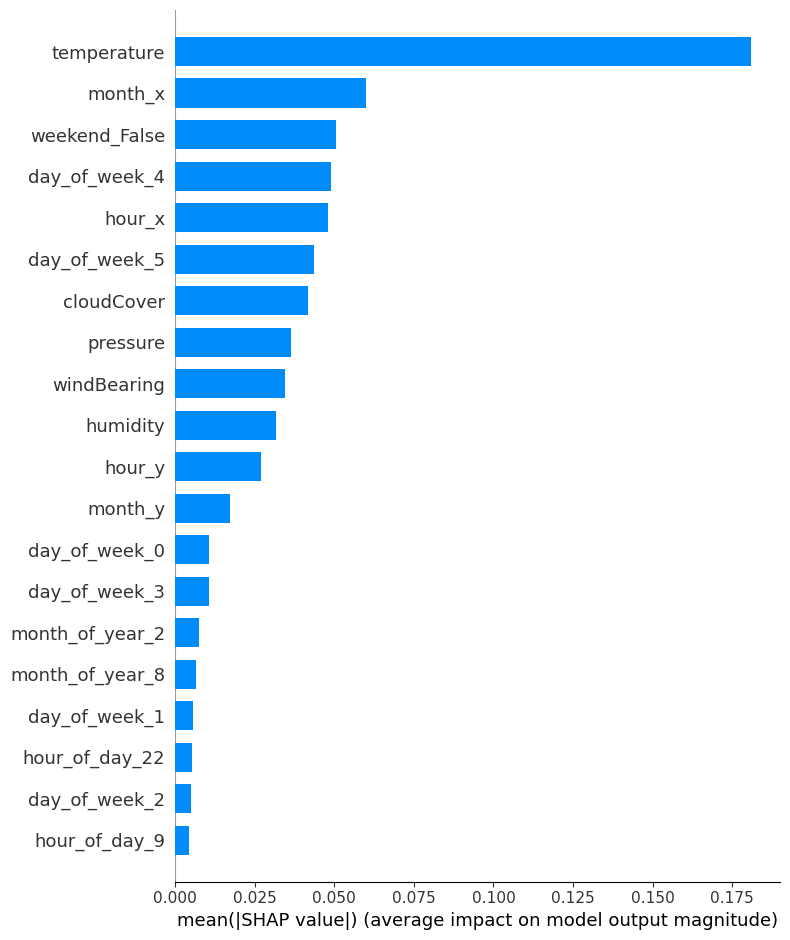

In [25]:
shap.summary_plot(shap_values, valid_x, plot_type='bar')


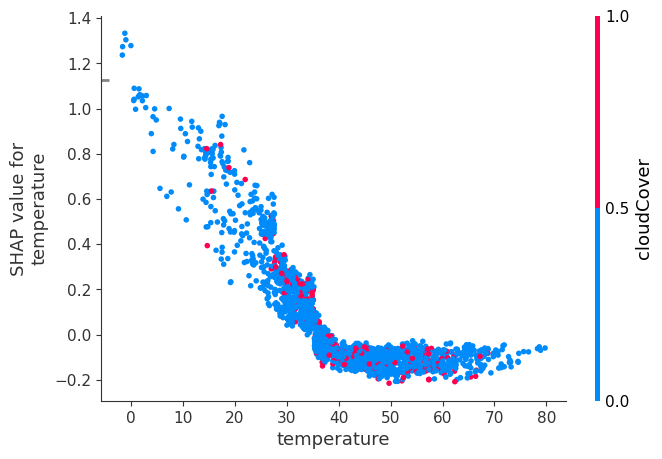

In [93]:
shap.dependence_plot("temperature", shap_values, valid_x, interaction_index="cloudCover")

In [98]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], valid_x.iloc[:1000,:])

In [96]:
explainer.expected_value

0.5947986702110714

In [81]:
shap_values[0]

.values =
array([ 1.80447805e-04, -4.45094444e-02, -3.09219489e-02,  3.15576437e-02,
        4.34663167e-03,  6.03526248e-03,  5.96573144e-03, -1.36657141e-02,
       -3.00883291e-02,  1.06680018e-01, -1.49519866e-04,  0.00000000e+00,
        0.00000000e+00, -1.09887374e-03,  8.54742052e-04, -1.05173715e-03,
        0.00000000e+00,  0.00000000e+00,  3.75969953e-04, -2.76986871e-04,
       -3.96274192e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.85926572e-02,  1.83025399e-05,  3.67218849e-04, -8.59340144e-05,
        3.17305951e-04,  0.00000000e+00, -5.44303948e-05, -7.01384785e-04,
       -3.65767365e-04, -1.02095759e-02, -1.86130650e-04,  0.00000000e+00,
       -2.89672918e-03,  0.00000000e+00, -6.08387583e-03,  2.54622370e-03,
        0.00000000e+00,  5.25560500e-05, -9.72588146e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.83156964e-02,
        0.00000000e+00, -1.11164188e-01,  2.94021168e-02,  4.61009379e-02,
       -5.67538

In [58]:
train_loop(bldg_df_1.drop(columns=['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']))

fit lightgbm to HomeD training start 2016-01-01 01:00:00 end 2016-10-01 12:00:00


0.8727853894233704

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [254]:
df = bldg_df_1[['power', 'temperature']]

In [33]:
cormat = bldg_df_1.corr()

In [34]:
cormat.head(1)

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity,cloudCover,windBearing,pressure
power,1.0,0.072614,0.076404,0.28719,0.244942,-0.068696,-0.070822,-0.08288,-0.023494,0.122466,...,-0.136625,-0.044832,0.214205,-0.094538,0.094538,-0.414956,-0.038258,0.043606,0.064605,0.060103


Text(0, 0.5, 'pearson')

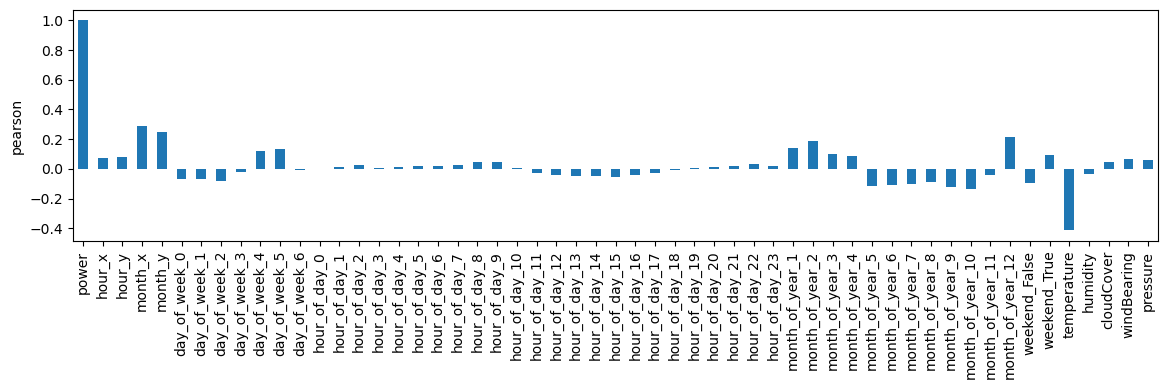

In [35]:
f,ax=plt.subplots(figsize=(14,3))
cormat.iloc[0].plot(kind='bar', ax=ax)
ax.set_ylabel('pearson')

In [258]:
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

Pandas computed Pearson r: -0.4149557589124109


In [259]:
r, p = stats.pearsonr(df['power'], df['temperature'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.414955758912411 and p-value: 0.0


In [260]:
df.corr()

,power,temperature
power,1.000000,-0.414956
temperature,-0.414956,1.000000


In [261]:
import numpy as np

[Text(0.5, 1.0, 'Overall Pearson r = -0.41')]

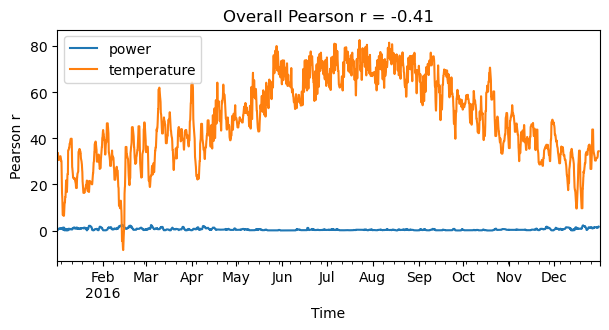

In [262]:
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}")

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Pearson r')]

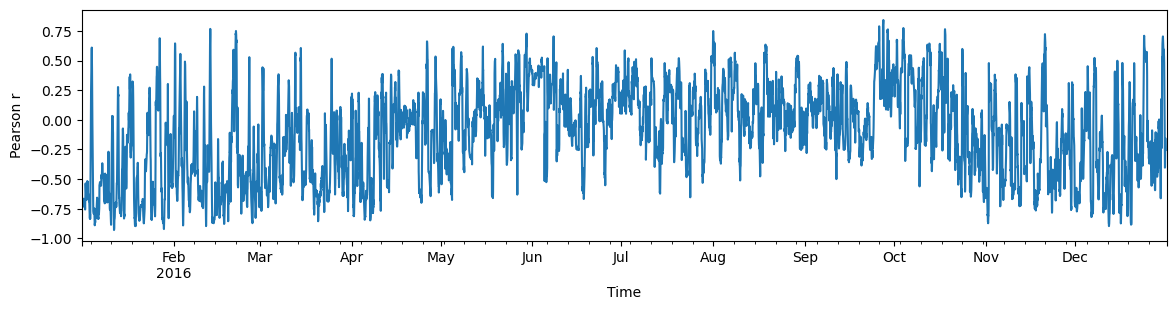

In [263]:
rolling_r =df['power'].rolling(window=24, center=True).corr(df['temperature'])
f,ax=plt.subplots(figsize=(14,3))
rolling_r.plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')


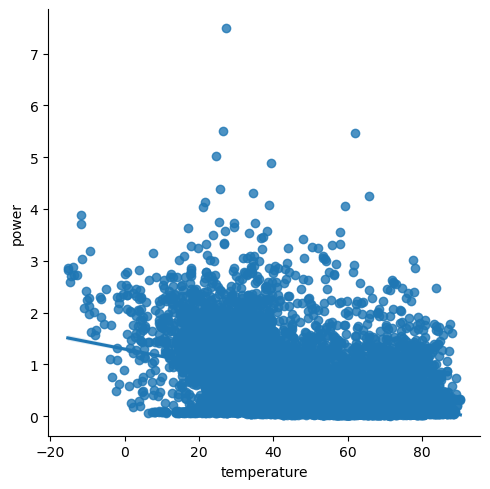

In [264]:
# sns.scatterplot(x=df['temperature'], y=df['power'])
ax = sns.lmplot(x="temperature", y="power", data=df)
ax.set_ylabels('power')
ax.set_xlabels('temperature')

In [239]:
df

,power,temperature
timestamp,,
2016-01-01 01:00:00,0.063468,34.79
2016-01-01 02:00:00,0.064494,34.08
2016-01-01 03:00:00,0.049928,34.02
2016-01-01 04:00:00,0.066187,34.00
2016-01-01 05:00:00,0.048459,33.89
...,...,...
2016-12-31 20:00:00,1.600637,26.25
2016-12-31 21:00:00,1.526326,22.26
2016-12-31 22:00:00,1.741415,20.47


In [240]:
df['temperature'].describe()

count    8783.000000
mean       49.124165
std        19.094167
min       -15.250000
25%        34.610000
50%        48.810000
75%        64.530000
max        90.210000
Name: temperature, dtype: float64